In [1]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd

import random
import os
import cv2
from sklearn.metrics import roc_curve, auc


import sys
sys.path.append('../scripts')
from utils import *

In [2]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1)

In [3]:
def get_curves(face_ids, n_out: int, trials: list = [0], pca_type: str = 'pca_all', base_dir: str = 'results_all'):
    fprs = []
    tprs = []
    for trial in trials:
        f_count = 0
        for face_id in face_ids:
            labels = np.load(f'./{base_dir}/labels/lbl_{n_out}_t{trial}.npy')
            pca_preds = np.load(f'./{base_dir}/{pca_type}/preds_{face_id}_{n_out}_t{trial}.npy')
            if f_count > 0:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
            f_count += 1
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC

        fpr, tpr, _ = roc_curve(labels, pca_preds_all, drop_intermediate=False)
        fprs.append(fpr)
        tprs.append(tpr)

    fpr = tolerant_mean(fprs)
    tpr = tolerant_mean(tprs)

    return fpr, tpr

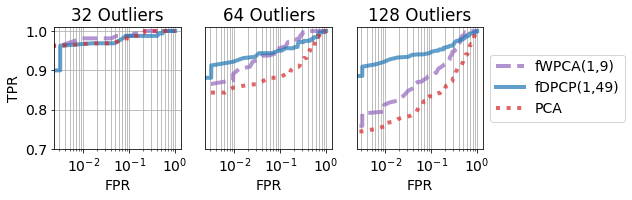

In [29]:
trials = [0,1,2,3,4]

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (9,3))


linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13))+list(np.arange(15,39)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

ax_num = 0
for n_out in [32,64,128]: #,64,128]:
    ii=0
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:

    # fpr, tpr = get_curves(face_ids, n_out, trials, 'pca_all')
    # axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA All', color = 'k')

    for pca_type, pca_label in zip(['wpca'], ['fWPCA(1,9)']):

        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = 'dashed', label = f'{pca_label}', color = 'tab:purple')# (AUC = {np.round(roc_auc,2)})')
        ii+=1


    for pca_type, pca_label in zip(['dpcp'], ['fDPCP(1,49)']):

        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = 'solid', label = f'{pca_label}', color = 'tab:blue')# (AUC = {np.round(roc_auc,2)})')
        ii+=1




    fpr, tpr = get_curves(face_ids, n_out, trials, 'pca')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = 'dotted', label = f'PCA', color = 'tab:red')# (AUC = {np.round(roc_auc,2)})')
    ii+=1



    # if ax_num > 0:
    #     axs[ax_num].set_yticks([])
    axs[ax_num].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[ax_num].set_title(f'{n_out} Outliers')
    axs[ax_num].set_xscale('log')
    axs[ax_num].grid(True, which="both")

    
    ax_num +=1


# axs[0].legend()
axs[0].set_ylim([.7,1.01])


# axs[1].set_xlim([0,1])
axs[1].set_ylim([.70, 1.01])
axs[1].set_yticks([])

# axs[2].set_xlim([0,1])
axs[2].set_ylim([.70, 1.01])
axs[2].set_yticks([])
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)



plt.tight_layout()
plt.savefig('faces_roc.pdf')


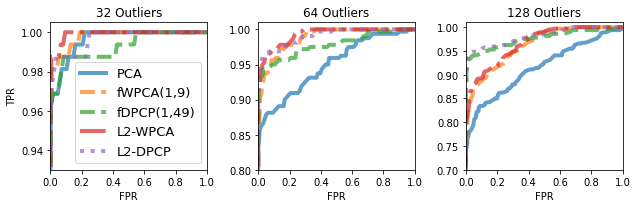

In [4]:
trials = [0,1,2,3,4]

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (9,3))


linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13))+list(np.arange(15,39)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

ax_num = 0
for n_out in [32,64,128]: #,64,128]:
    ii=0
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:

    # fpr, tpr = get_curves(face_ids, n_out, trials, 'pca_all')
    # axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA All', color = 'k')

    fpr, tpr = get_curves(face_ids, n_out, trials, 'pca')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    for pca_type, pca_label in zip(['wpca', 'dpcp'], ['fWPCA(1,9)', 'fDPCP(1,49)']):

        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'{pca_label}')# (AUC = {np.round(roc_auc,2)})')
        ii+=1

    fpr, tpr = get_curves(face_ids, n_out, trials, 'wpca_base')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'L2-WPCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1

    fpr, tpr = get_curves(face_ids, n_out, trials, 'dpcp_base')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'L2-DPCP')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    # if ax_num > 0:
    #     axs[ax_num].set_yticks([])
    axs[ax_num].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[ax_num].set_title(f'{n_out} Outliers')

    
    ax_num +=1


# axs[0].legend()
axs[0].set_xlim([0,1])
axs[0].set_ylim([.93,1.005])

axs[1].set_xlim([0,1])
axs[1].set_ylim([.8, 1.01])

axs[2].set_xlim([0,1])
axs[2].set_ylim([.70, 1.01])
axs[0].legend(fontsize = 13)

plt.tight_layout()
plt.savefig('faces_roc.pdf')


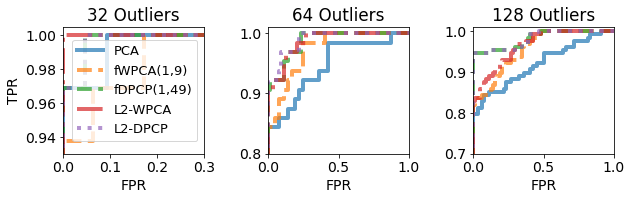

In [9]:
trials = [0]

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (9,3))


linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13))+list(np.arange(15,19)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

ax_num = 0
for n_out in [32,64,128]: #,64,128]:
    ii=0
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:

    # fpr, tpr = get_curves(face_ids, n_out, trials, 'pca_all')
    # axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA All', color = 'k')

    fpr, tpr = get_curves(face_ids, n_out, trials, 'pca')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    for pca_type, pca_label in zip(['wpca1', 'dpcp1'], ['fWPCA(1,9)', 'fDPCP(1,49)']):

        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'{pca_label}')# (AUC = {np.round(roc_auc,2)})')
        ii+=1

    fpr, tpr = get_curves(face_ids, n_out, trials, 'wpca_base')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'L2-WPCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1

    fpr, tpr = get_curves(face_ids, n_out, trials, 'dpcp_base')
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'L2-DPCP')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    # if ax_num > 0:
    #     axs[ax_num].set_yticks([])
    axs[ax_num].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[ax_num].set_title(f'{n_out} Outliers')

    
    ax_num +=1


# axs[0].legend()
axs[0].set_xlim([0,.3])
axs[0].set_ylim([.93,1.005])

axs[1].set_xlim([0,1])
axs[1].set_ylim([.8, 1.01])

axs[2].set_xlim([0,1])
axs[2].set_ylim([.70, 1.01])
axs[0].legend(fontsize = 13)

plt.tight_layout()
# plt.savefig('faces_roc.pdf')


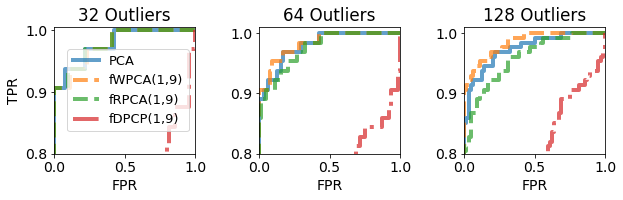

In [18]:
trials = [0]

cropped_dir = 'results_cropped'

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (9,3))


linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

ax_num = 0
for n_out in [32,64,128]: #,64,128]:
    ii=0
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:

    # fpr, tpr = get_curves(face_ids, n_out, trials, 'pca_all')
    # axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA All', color = 'k')

    fpr, tpr = get_curves(face_ids, n_out, trials, 'pca', base_dir = cropped_dir)
    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    for pca_type, pca_label in zip(['wpca', 'rpca', 'dpcp'], ['fWPCA(1,9)', 'fRPCA(1,9)', 'fDPCP(1,9)']):
        
        fpr, tpr = get_curves(face_ids, n_out, trials, pca_type, base_dir = cropped_dir)
        axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 4, linestyle = linestyles[ii], label = f'{pca_label}')# (AUC = {np.round(roc_auc,2)})')
        ii+=1



    # if ax_num > 0:
    #     axs[ax_num].set_yticks([])
    axs[ax_num].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[ax_num].set_title(f'{n_out} Outliers')

    
    ax_num +=1


# axs[0].legend()
axs[0].set_xlim([0,1])
axs[0].set_ylim([.8,1.005])

axs[1].set_xlim([0,1])
axs[1].set_ylim([.8, 1.01])

axs[2].set_xlim([0,1])
axs[2].set_ylim([.8, 1.01])
axs[0].legend(fontsize = 13)

plt.tight_layout()
plt.savefig('faces_cropped_roc.pdf')


In [22]:
def load_inliers(ii):
    yale_faces = []

    base_dir  = './data/CroppedYale/'
    subject_id = sorted(os.listdir(base_dir))[ii]
    if '.DS' not in subject_id:
        subject_dir = os.path.join(base_dir, subject_id)
        for file_id in sorted(os.listdir(subject_dir)):
            if ('.pgm' in file_id) and ('Ambient' not in file_id):
                file_dir = os.path.join(subject_dir, file_id)
                image = plt.imread(file_dir)
                small_image = cv2.resize(image, dsize=(52,48), interpolation=cv2.INTER_CUBIC)
                yale_faces.append(small_image.flatten())

    yale_faces = np.vstack(yale_faces)
    n_in = len(yale_faces)

    return yale_faces, n_in, subject_id[-2:]

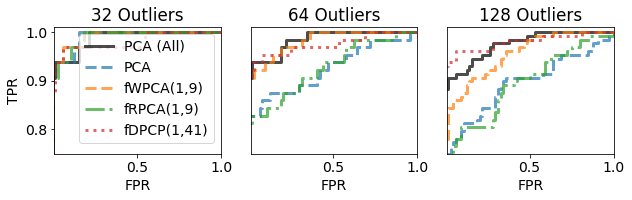

In [94]:

linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13))+list(np.arange(15,39)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(1,3, figsize = (9,3))
ax_num = 0
for n_out in [32,64,128]: #,64,128]:
    ii=1
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    
    axs[ax_num].set_title(f'{n_out} Outliers')

    pca_type = 'pca_all'
    f_count = 0
    for face_id in face_ids:
        _, n_in = load_inliers(face_id)
        labels = np.load(f'./results_all/labels/lbl_{n_out}_t{trial}.npy')
        pca_preds = np.load(f'./results_all/{pca_type}/preds_{face_id}_{n_out}_t1.npy')
        if f_count > 0:
            pca_preds_all += pca_preds
        else:
            pca_preds_all = pca_preds
        f_count += 1

    pca_preds_all = pca_preds_all/np.max(pca_preds_all)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
    roc_auc = auc(fpr, tpr)

    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 3, label = f'PCA (All)', color = 'k')# (AUC = {np.round(roc_auc,2)})')

    pca_type = 'pca'
    f_count = 0
    for face_id in face_ids:
        _, n_in = load_inliers(face_id)
        labels = np.load(f'./results_all/labels/lbl_{n_out}_t{trial}.npy')
        pca_preds = np.load(f'./results_all/{pca_type}/preds_{face_id}_{n_out}_t1.npy')
        if f_count > 0:
            pca_preds_all += pca_preds
        else:
            pca_preds_all = pca_preds
        f_count += 1

    pca_preds_all = pca_preds_all/np.max(pca_preds_all)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
    roc_auc = auc(fpr, tpr)

    axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})')
    ii+=1


    for fl_type in [[1,3]]:

        for pca_type, pca_label in zip(['wpca', 'rpca', 'dpcp'], ['fWPCA(1,9)', 'fRPCA(1,9)', 'fDPCP(1,41)']):
            f_count = 0
            for face_id in face_ids:
                _, n_in = load_inliers(face_id)
                labels = np.load(f'./results_all/labels/lbl_{n_out}_t{trial}.npy')
                pca_preds = np.load(f'./results_all/{pca_type}/preds_{face_id}_{n_out}_t1.npy')
                if f_count > 0:
                    pca_preds_all += pca_preds
                else:
                    pca_preds_all = pca_preds
                f_count += 1
        
            pca_preds_all = pca_preds_all/np.max(pca_preds_all)
            # Compute ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
            roc_auc = auc(fpr, tpr)

            axs[ax_num].plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'{pca_label}')# (AUC = {np.round(roc_auc,2)})')
            ii+=1

    axs[ax_num].set_xlim([.01,1])
    axs[ax_num].set_ylim([.75, 1.01])

    if ax_num > 0:
        axs[ax_num].set_yticks([])
    axs[ax_num].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')

    
    ax_num +=1


axs[0].legend()
plt.tight_layout()
# plt.savefig('faces_roc.pdf')


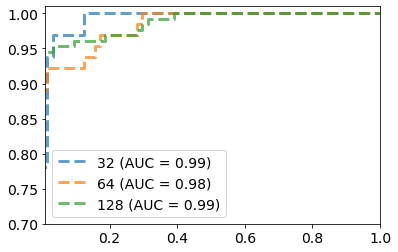

In [72]:
face_num = 1
linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

face_ids = []
for f in list(np.arange(1,13))+list(np.arange(15,39)):
    if f < 10:
        face_ids.append(f'0{f}')
    else:
        face_ids.append(str(f))

for n_out in [32,64,128]: #,64,128]:
    ii=1
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    for fl_type in [[1,3]]:
        for face_id in face_ids:
            _, n_in = load_inliers(face_id)
            labels = np.array(n_in*[0] + n_out*[1])
            pca_preds = np.load(f'./results_all/dpcp/preds_{face_id}_{n_out}_t0.npy')
            if face_num > 1:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
    
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'{n_out} (AUC = {np.round(roc_auc,2)})')
        ii+=1

    plt.xlim([.01,1])
    plt.ylim([.7, 1.01])
    plt.legend()


In [68]:
face_ids

['01',
 '10',
 '13',
 '26',
 '31',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38']

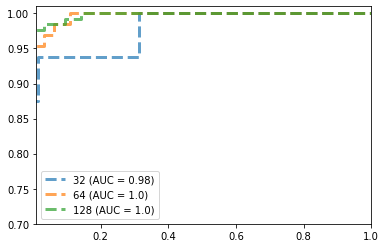

In [24]:
face_num = 1
linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

for n_out in [32,64,128]: #,64,128]:
    ii=1
    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    for fl_type in [[1,3]]:
        face_ids = ['01','10','13','26','31']
        for face_id in face_ids:
            _, n_in = load_inliers(face_id)
            labels = np.array(n_in*[0] + n_out*[1])
            pca_preds = np.load(f'./results_all/dpcp/preds_{face_id}_{n_out}.npy')
            if face_num > 1:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
    
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'{n_out} (AUC = {np.round(roc_auc,2)})')
        ii+=1

    plt.xlim([.01,1])
    plt.ylim([.7, 1.01])
    plt.legend()


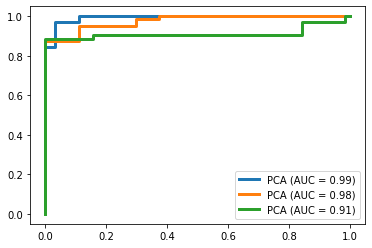

In [30]:
def load_inliers1(face_num):
    yale_faces = []

    base_dir  = './data/CroppedYale/'
    subject_id = os.listdir(base_dir)[face_num]
    if '.DS' not in subject_id:
        subject_dir = os.path.join(base_dir, subject_id)
        for file_id in os.listdir(subject_dir):
            if ('.pgm' in file_id) and ('Ambient' not in file_id):
                file_dir = os.path.join(subject_dir, file_id)
                image = plt.imread(file_dir)
                small_image = cv2.resize(image, dsize=(30,30), interpolation=cv2.INTER_CUBIC)
                yale_faces.append(small_image.flatten())

    yale_faces = np.vstack(yale_faces)
    n_in = len(yale_faces)

    return yale_faces, n_in

face_num = 1
linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

for n_out in [32,64,128]: #,64,128]:



    for face_num in list(np.arange(1,6)):

        _, n_in = load_inliers1(face_num)
        labels = np.array(n_in*[0] + n_out*[1])

        pca_preds = np.load(f'./results/pca/preds_{face_num}_{n_out}.npy')
        if face_num > 1:
            pca_preds_all += pca_preds
        else:
            pca_preds_all = pca_preds
    
    pca_preds_all = pca_preds_all/np.max(pca_preds_all)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
    roc_auc = auc(fpr, tpr)


    ii=0

    plt.plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA (AUC = {np.round(roc_auc,2)})')
    plt.legend()

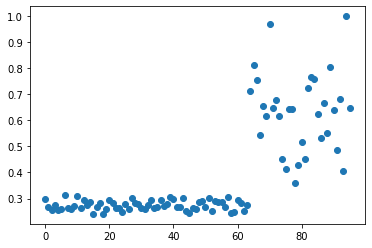

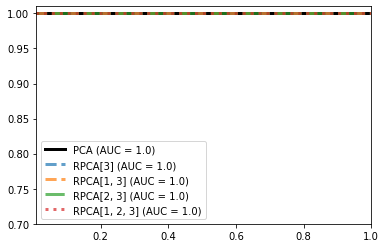

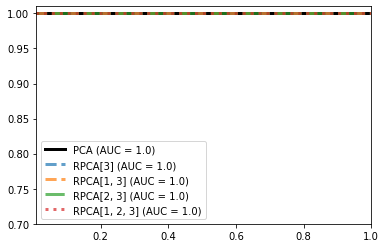

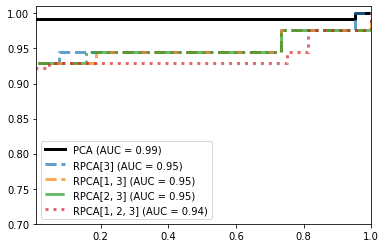

In [13]:
face_num = 1
linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

for n_out in [32,64,128]: #,64,128]:



    for face_num in list(np.arange(1,10))+list(np.arange(11,23)):

        _, n_in = load_inliers(face_num)
        labels = np.array(n_in*[0] + n_out*[1])

        pca_preds = np.load(f'./results/pca/preds_{face_num}_{n_out}.npy')
        if face_num > 1:
            pca_preds_all += pca_preds
        else:
            pca_preds_all = pca_preds
    
    pca_preds_all = pca_preds_all/np.max(pca_preds_all)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
    roc_auc = auc(fpr, tpr)

    plt.scatter(np.arange(len(pca_preds_all)), pca_preds_all)

    ii=0
    plt.figure()
    plt.plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA (AUC = {np.round(roc_auc,2)})', color = 'k')
    ii+=1



    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
        face_nums = list(np.arange(1,23))+list(np.arange(24,38))
        for face_num in face_nums:
            pca_preds = np.load(f'./results/rpca/preds_{face_num}_{fl_type}_{n_out}.npy')
            if face_num > 1:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
    
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'RPCA{fl_type} (AUC = {np.round(roc_auc,2)})')
        ii+=1

    plt.xlim([.01,1])
    plt.ylim([.7, 1.01])
    plt.legend()


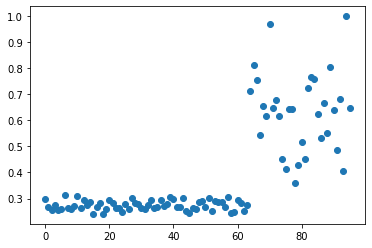

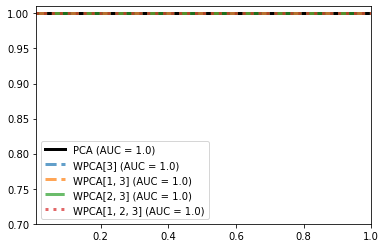

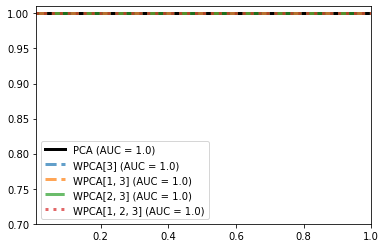

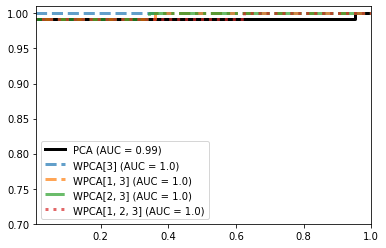

In [16]:
face_num = 1
linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

for n_out in [32,64,128]: #,64,128]:



    for face_num in list(np.arange(1,10))+list(np.arange(11,23)):

        _, n_in = load_inliers(face_num)
        labels = np.array(n_in*[0] + n_out*[1])

        pca_preds = np.load(f'./results/pca/preds_{face_num}_{n_out}.npy')
        if face_num > 1:
            pca_preds_all += pca_preds
        else:
            pca_preds_all = pca_preds
    
    pca_preds_all = pca_preds_all/np.max(pca_preds_all)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
    roc_auc = auc(fpr, tpr)

    plt.scatter(np.arange(len(pca_preds_all)), pca_preds_all)

    ii=0
    plt.figure()
    plt.plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA (AUC = {np.round(roc_auc,2)})', color = 'k')
    ii+=1



    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
        face_nums = list(np.arange(1,10))+list(np.arange(11,23))
        for face_num in face_nums:
            pca_preds = np.load(f'./results/wpca/preds_{face_num}_{fl_type}_{n_out}.npy')
            if face_num > 1:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
    
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'WPCA{fl_type} (AUC = {np.round(roc_auc,2)})')
        ii+=1

    plt.xlim([.01,1])
    plt.ylim([.7, 1.01])
    plt.legend()


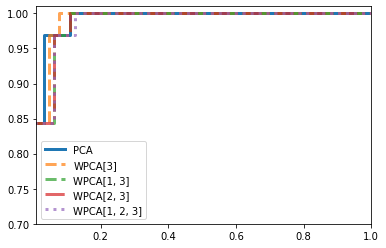

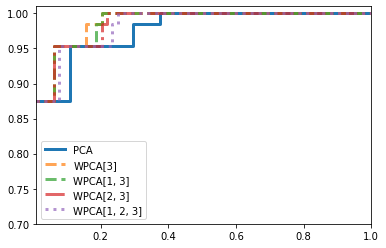

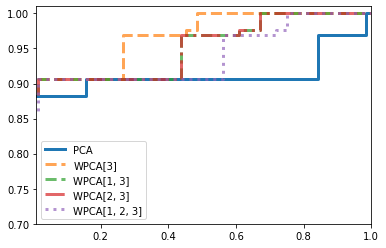

In [13]:
face_num = 1
linestyles = ['solid', '--', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

for n_out in [32,64,128]: #,64,128]:



    for face_num in [1,2,3,4,5]:

        _, n_in = load_inliers(face_num)
        labels = np.array(n_in*[0] + n_out*[1])

        pca_preds = np.load(f'./results/pca/preds_{face_num}_{n_out}.npy')
        if face_num > 1:
            pca_preds_all += pca_preds
        else:
            pca_preds_all = pca_preds
    
    pca_preds_all = pca_preds_all/np.max(pca_preds_all)
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
    roc_auc = auc(fpr, tpr)

    ii=0
    plt.figure()
    plt.plot(fpr, tpr, lw = 3, linestyle = linestyles[ii], label = f'PCA')# (AUC = {np.round(roc_auc,2)})', color = 'k')
    ii+=1



    # for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
        for face_num in [1,2,3,4,5,6]:
            pca_preds = np.load(f'./results/wpca/preds_{face_num}_{fl_type}_{n_out}.npy')
            if face_num > 1:
                pca_preds_all += pca_preds
            else:
                pca_preds_all = pca_preds
    
        pca_preds_all = pca_preds_all/np.max(pca_preds_all)
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(labels, pca_preds_all)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, alpha = .7, lw = 3, linestyle = linestyles[ii], label = f'WPCA{fl_type}')# (AUC = {np.round(roc_auc,2)})')
        ii+=1

    plt.xlim([.01,1])
    plt.ylim([.7, 1.01])
    plt.legend()


In [10]:
os.listdir('/Users/natemankovich/Documents/PostDoc/FunWithFlags2024/Faces/data/CroppedYale')[23]

'yaleB30'

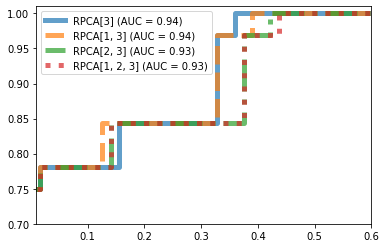

In [13]:
aucs = pd.read_csv('results/small/aucs.csv', index_col=0)


linestyles = ['solid', '--', '-.', ':', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
ii=0
for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    idx = aucs['Flag Type'] == str(fl_type)
    auc = np.round(aucs[idx]['AUC'].values[0],2)

    fpr = np.load(f'results/small/fpr{fl_type}_32.npy')
    tpr = np.load(f'results/small/tpr{fl_type}_32.npy')

    plt.plot(fpr, tpr, alpha = .7, lw = 5, linestyle = linestyles[ii], label = f'RPCA{fl_type} (AUC = {auc})')
    ii+=1

plt.xlim([.01,.6])
plt.ylim([.7, 1.01])
plt.legend()


In [23]:

for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    all_aucs = []
    for face_num in range(1,11):
        aucs = pd.read_csv(f'results/wpca/{face_num}_aucs.csv', index_col = 0)
        idx = aucs['Flag Type'] == str(fl_type)
        auc = aucs[idx]['AUC'].values[0]
    print(np.mean(auc))




0.9287109375
0.923828125
0.9287109375
0.92578125


In [25]:
# this was with the different error detection methods
face_num = 1
linestyles = ['solid', '--', '-.', ':', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
fprs = []
tprs = []
for fl_type in [[3], [1,3],[2,3], [1,2,3]]:
    for face_num in range(1,11):
        fprs.append(len(np.load(f'/Users/natemankovich/Documents/PostDoc/FunWithFlags2024/Faces/results/wpca/fpr_{face_num}_{fl_type}_32.npy')))
        tprs.append(len(np.load(f'/Users/natemankovich/Documents/PostDoc/FunWithFlags2024/Faces/results/wpca/tpr_{face_num}_{fl_type}_32.npy')))

print(np.max(fprs), np.max(tprs))
print(np.min(fprs), np.min(tprs))

22 22
17 17


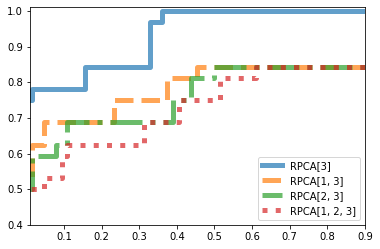

In [10]:
# this was with the different error detection methods

linestyles = ['solid', '--', '-.', ':', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]
ii=0
for fl_type in [[3], [1,3],[2,3],[1,2,3]]:
    fpr = np.load(f'/Users/natemankovich/Documents/PostDoc/FunWithFlags2024/Faces/results/wpca/fpr{fl_type}_32.npy')
    tpr = np.load(f'/Users/natemankovich/Documents/PostDoc/FunWithFlags2024/Faces/results/wpca/tpr{fl_type}_32.npy')

    plt.plot(fpr, tpr, alpha = .7, lw = 5, linestyle = linestyles[ii], label = f'RPCA{fl_type}')
    ii+=1

plt.xlim([.01,.9])
plt.ylim([.4, 1.01])
plt.legend()
